In [8]:
import datetime
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import plotly.express as px
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
df_tsne = pd.read_csv(r"data/df_tsne_3components.csv")
df_pca = pd.read_csv(r"data/df_pca_45components.csv")
df_mca = pd.read_csv(r"data/df_mca_134components.csv")
df_umap = pd.read_csv(r"data/df_umap_3components.csv")

## <span style='color:#ff5f27'>🎯 [KMeans](https://www.analyticsvidhya.com/blog/2019/08/comprehensive-guide-k-means-clustering/) algorithm
    
    
### Here I will perform basic clustering algorithm to the different transformed dataframes and compare results, visually and then mathematically

Elbow Method using dataframe transformed by PCA to determine the number of clusters to be formed:


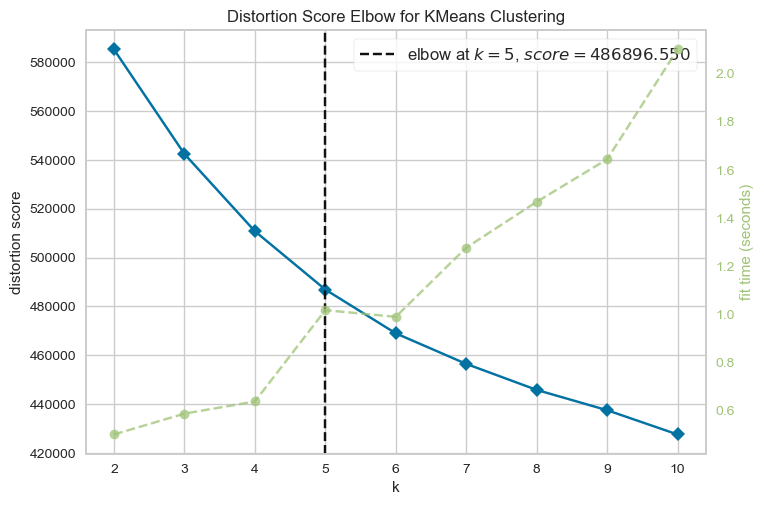

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [4]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method using dataframe transformed by PCA to determine the number of clusters to be formed:')
elbow_method = KElbowVisualizer(KMeans(), k=10)
elbow_method.fit(df_pca)
elbow_method.show()

Elbow Method using dataframe transformed by MCA to determine the number of clusters to be formed:


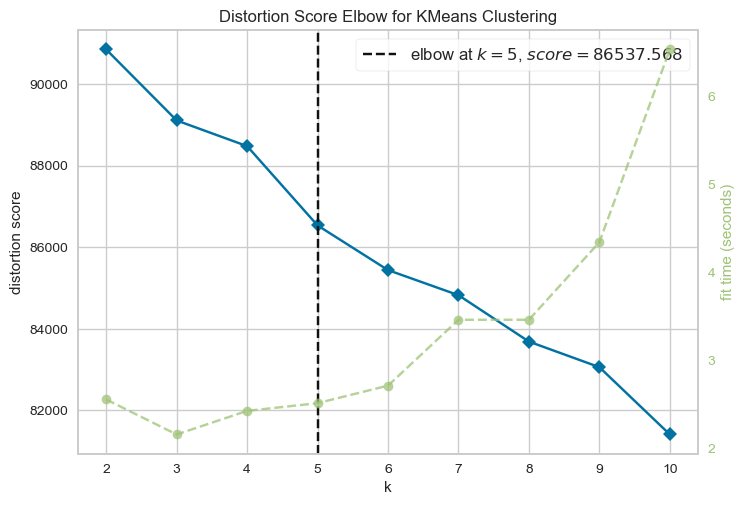

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method using dataframe transformed by MCA to determine the number of clusters to be formed:')
elbow_method = KElbowVisualizer(KMeans(), k=10)
elbow_method.fit(df_mca)
elbow_method.show()

Elbow Method using dataframe transformed by UMAP to determine the number of clusters to be formed:


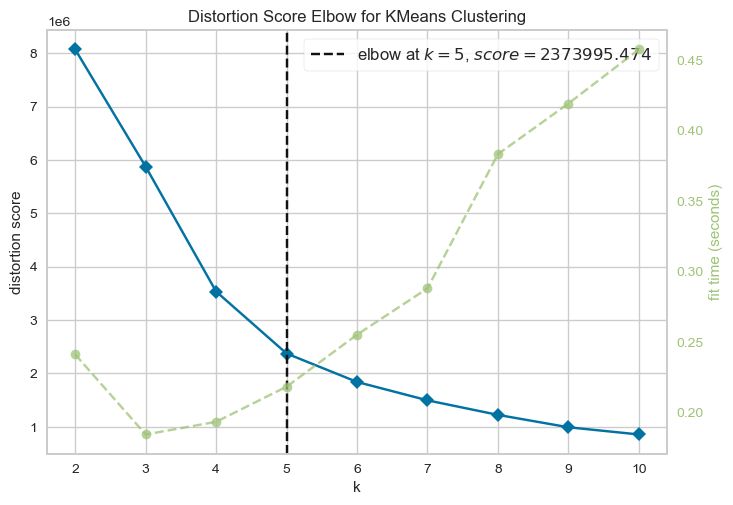

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [6]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method using dataframe transformed by UMAP to determine the number of clusters to be formed:')
elbow_method = KElbowVisualizer(KMeans(), k=10)
elbow_method.fit(df_umap)
elbow_method.show()

### After precise look at these 3 charts, I decided that the `optimal k-value is 5`.

---

### I decided to use both t-SNE and UMAP 3-d representations of original data to visualize and compare clustering results.

#### UMAP aims to preserve both local and global structure, while t-SNE primarily focuses on preserving pairwise similarities between data points. As a result, the clusters identified by K-Means in the transformed space may differ.



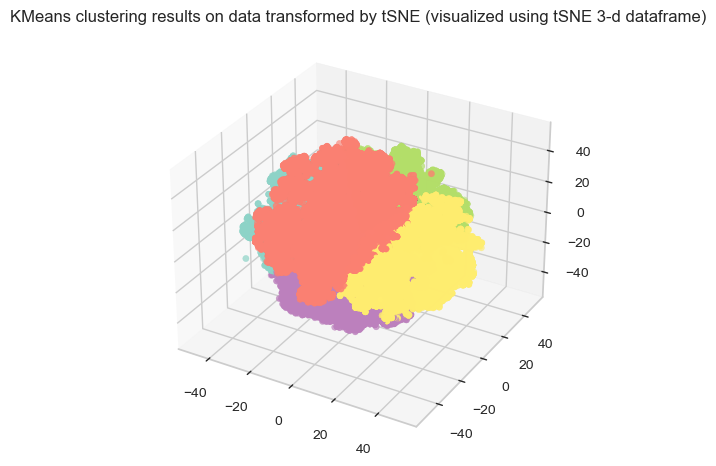

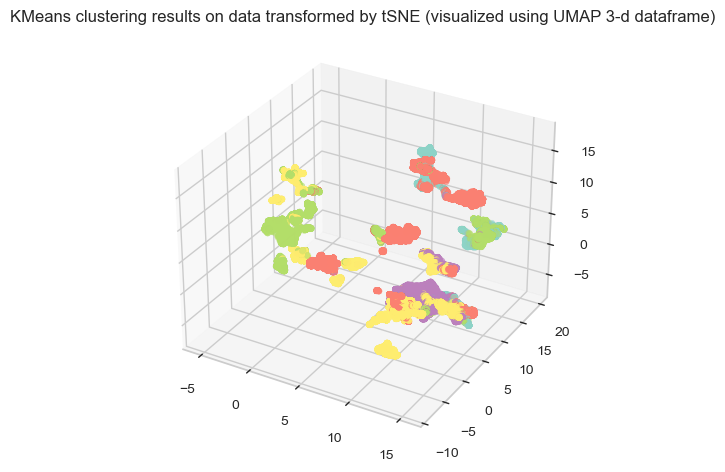

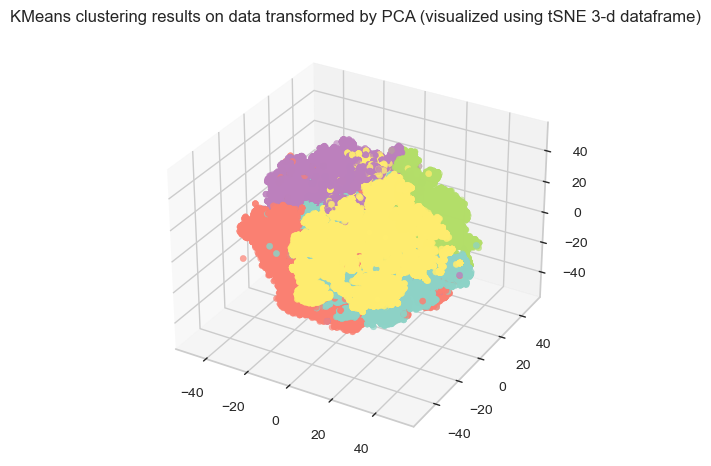

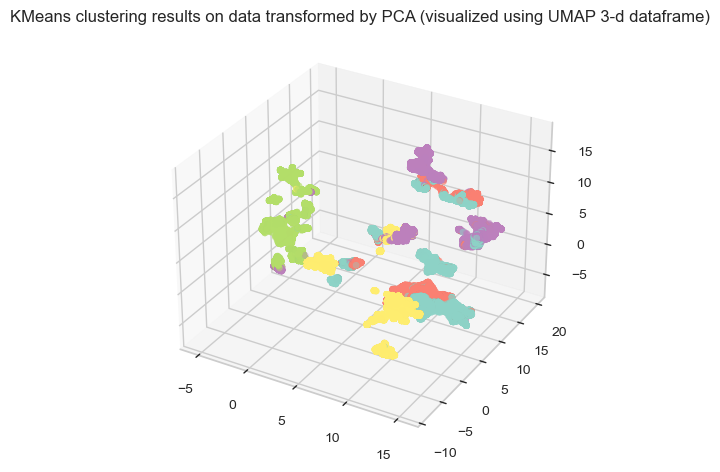

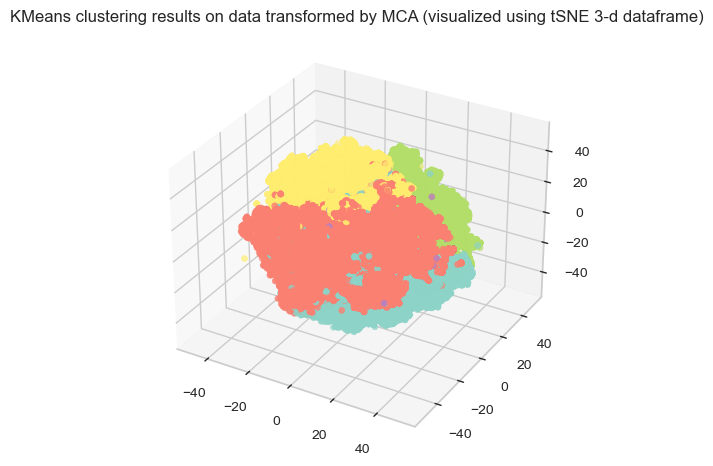

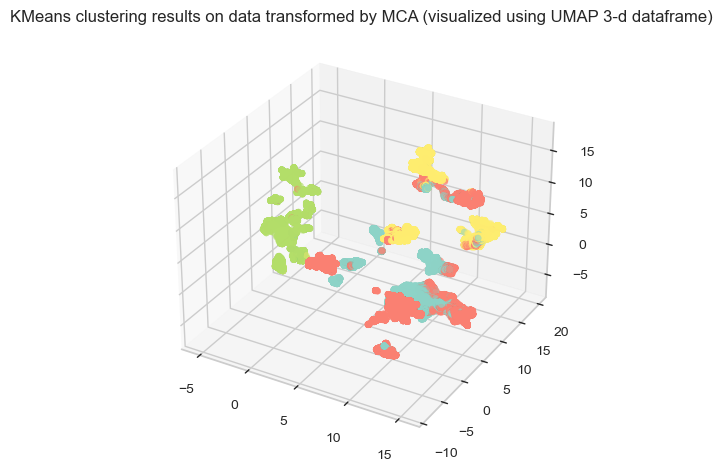

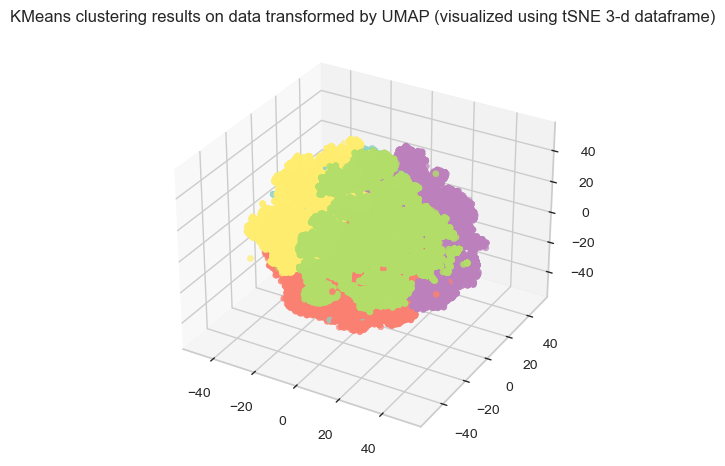

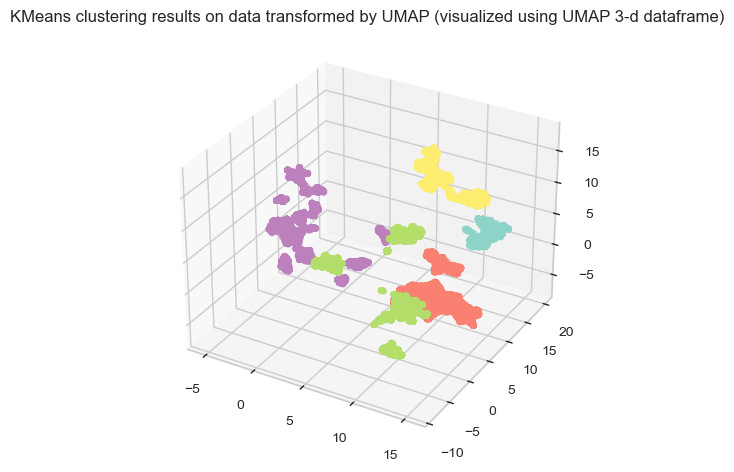

In [9]:
n_clusters = 5


# Initialize an empty DataFrame to hold clustering results
columns = pd.MultiIndex.from_product([['kmeans', 'dbscan', 'birch'], ['tSNE', 'PCA', 'MCA', 'UMAP']], names=['Clustering', 'Dimensionality Reduction'])

# Create the DataFrame with the MultiIndex
clustering_results_df = pd.DataFrame(columns=columns)

# Iterate through transformed data frames obtained using various dimensionality reduction algorithms
for df_transformed, df_transformed_name in zip([df_tsne, df_pca, df_mca, df_umap],
                                               ["tSNE", "PCA", "MCA", "UMAP"]):
    # Initiating the KMeans Clustering model
    kmeans = KMeans(n_clusters=n_clusters)
    # Fit model and predict clusters
    kmeans_cluster = kmeans.fit_predict(df_transformed)
    
    # Insert the data into the DataFrame
    clustering_results_df.loc[:, ('kmeans', df_transformed_name)] = kmeans_cluster

    # Iterate through "visualization" dataframes (the 3-d ones, to visualize results of the clustering step above)
    for df_vis, df_vis_name in zip([df_tsne, df_umap], ["tSNE", "UMAP"]):
        df_visual = df_vis.copy()
        df_visual["kmeans_cluster"] = kmeans_cluster

        x = df_visual['col_0']
        y = df_visual['col_1']
        z = df_visual['col_2']
        colors = df_visual['kmeans_cluster']

        # Choose a colormap (replace 'coolwarm' with the desired colormap)
        colormap = plt.get_cmap('Set3')

        # Create a 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c=colors, cmap=colormap)

        # Set a title for the plot
        ax.set_title('KMeans clustering results on data transformed by {} (visualized using {} 3-d dataframe)'.format(
            df_transformed_name, df_vis_name))
        
        # Define the file name
        file_name = f'plots/kmeans/{df_transformed_name}_df_represented_by_{df_vis_name}.png'

        # Remove the existing file if it exists
        try:
            os.remove(file_name)
        except OSError:
            pass

        # Save the plot as an image file (e.g., PNG)
        plt.savefig(file_name)

        # Show the plot
        plt.show()

### Run the cell below to construct an interactive 3-d graphs

In [20]:
# for df_transformed, df_transformed_name in zip([df_tsne, df_pca, df_mca, df_umap],
#                                                ["tSNE", "PCA", "MCA", "UMAP"]):
#     for df_vis, df_viz_name in zip([df_tsne, df_umap], ["tSNE", "UMAP"]):
#         df_visual = df_vis.copy()
#         selected_column = [col for col in clustering_results_df.columns if df_transformed_name in col][0]
#         df_visual["kmeans_cluster"] = clustering_results_df[selected_column]
#         fig = px.scatter_3d(df_visual, x='col_0', y='col_1', z='col_2', color="kmeans_cluster",
#                            title='KMeans clustering results on data transformed by {} (visualized using {} 3-d dataframe)'
#                               .format(df_transformed_name, df_viz_name))
#         fig.show()

## Visually, with KMeans, UMAP showed the best result.

---

## <span style='color:#ff5f27'> 🔘 [DBSCAN (Density-Based Spatial Clustering of Applications with Noise)](https://www.analyticsvidhya.com/blog/2020/09/how-dbscan-clustering-works/) algorithm

Processing epc=0.3 for different min_samples values...

Processing epc=0.35 for different min_samples values...

Processing epc=0.39999999999999997 for different min_samples values...

Processing epc=0.44999999999999996 for different min_samples values...

Processing epc=0.49999999999999994 for different min_samples values...

Processing epc=0.5499999999999999 for different min_samples values...

Processing epc=0.5999999999999999 for different min_samples values...

Processing epc=0.6499999999999999 for different min_samples values...

Processing epc=0.7 for different min_samples values...

Processing epc=0.7499999999999999 for different min_samples values...

Processing epc=0.7999999999999998 for different min_samples values...

Processing epc=0.8499999999999999 for different min_samples values...

Processing epc=0.8999999999999999 for different min_samples values...

Processing epc=0.95 for different min_samples values...

Processing epc=0.9999999999999998 for different min_samples v

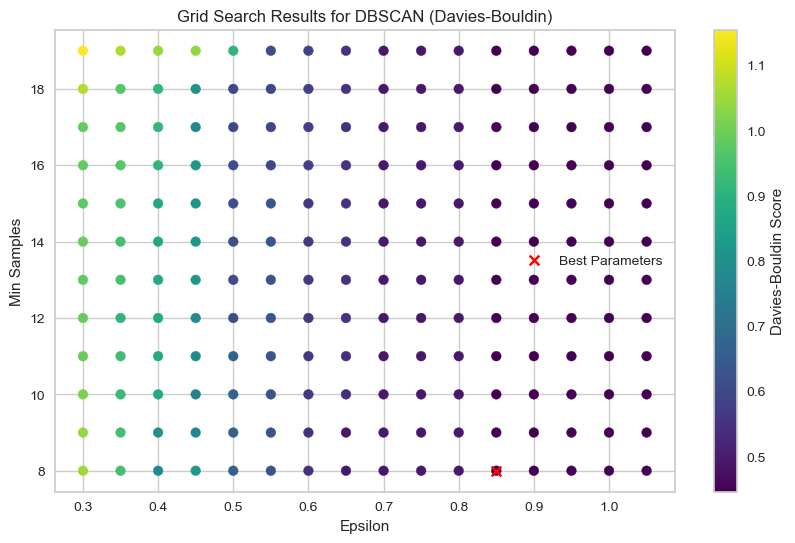

In [7]:
# Range of parameter values to explore
eps_values = np.arange(0.3, 1.1, 0.05)
min_samples_values = range(8, 20, 1)

# Store Davies-Bouldin scores for each parameter combination
davies_bouldin_scores = []

for eps in eps_values:
    print(f"Processing epc={eps} for different min_samples values...")
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(df_umap)
        
         # Ignore cases where all labels are -1 (no clusters formed)
        if len(set(labels)) > 1:
            davies_bouldin = davies_bouldin_score(df_umap, labels)
            davies_bouldin_scores.append((eps, min_samples, davies_bouldin))
    print()
    
# Convert Davies-Bouldin scores to a NumPy array
davies_bouldin_scores = np.array(davies_bouldin_scores)

# Find the index with the lowest Davies-Bouldin score
best_idx = np.argmin(davies_bouldin_scores[:, 2])

# Extract the best parameters
best_eps = davies_bouldin_scores[best_idx, 0]
best_min_samples = davies_bouldin_scores[best_idx, 1]

print("Best parameters:")
print("Epsilon:", best_eps)
print("Min Samples:", best_min_samples)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(davies_bouldin_scores[:, 0], davies_bouldin_scores[:, 1], c=davies_bouldin_scores[:, 2], cmap='viridis')
plt.xlabel('Epsilon')
plt.ylabel('Min Samples')
plt.title('Grid Search Results for DBSCAN (Davies-Bouldin)')
plt.colorbar(label='Davies-Bouldin Score')
plt.scatter(best_eps, best_min_samples, color='red', marker='x', label='Best Parameters')
plt.legend()
plt.grid(True)
plt.show()

Best parameters:
- Epsilon: 0.85

- Min Samples: 8.0

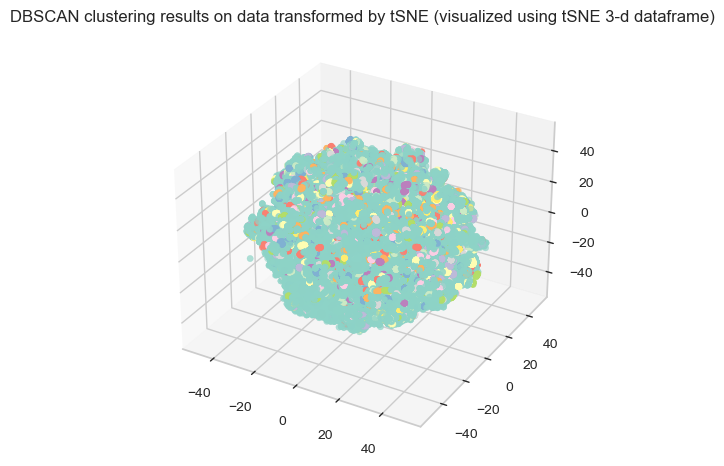

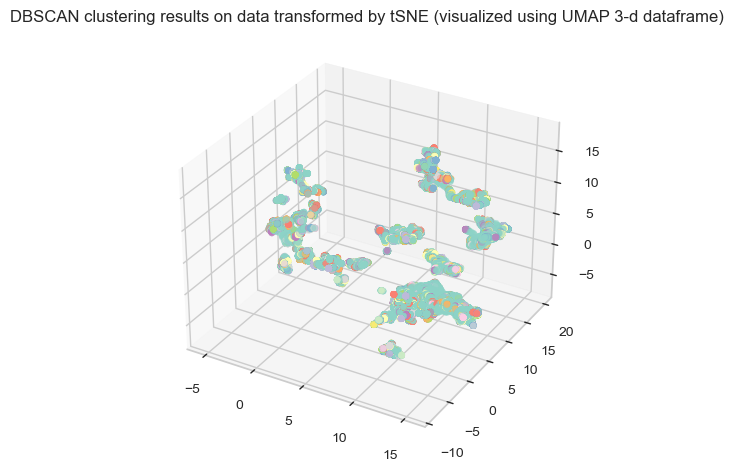

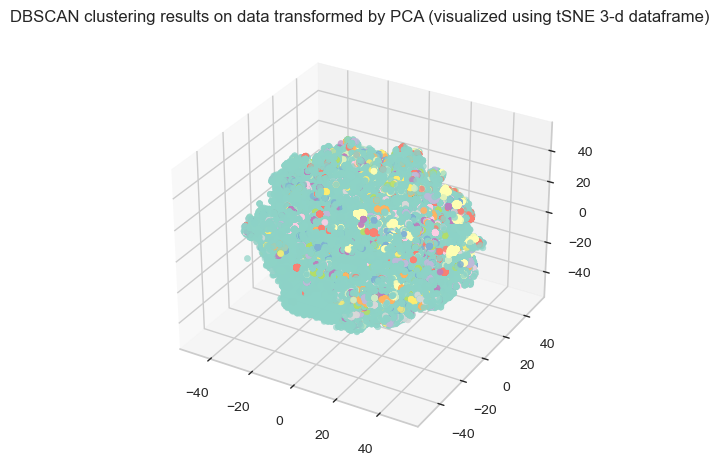

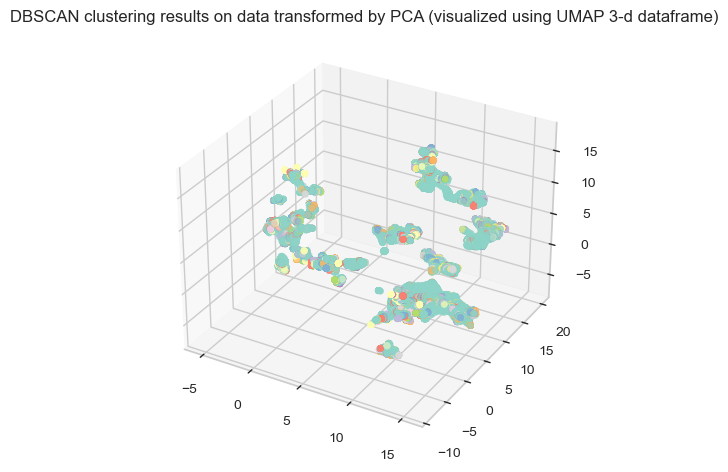

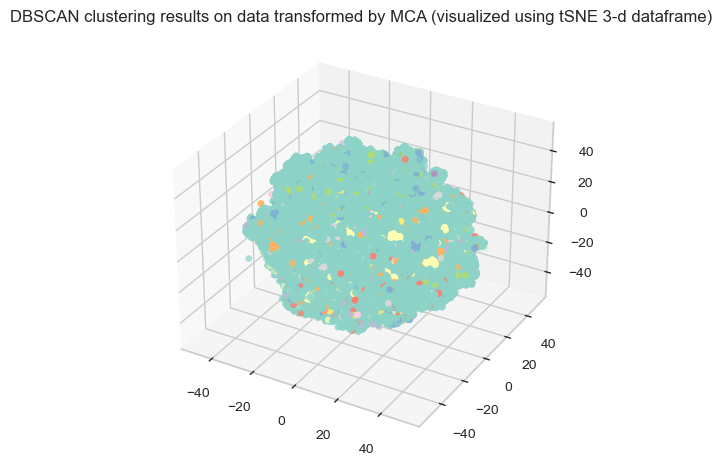

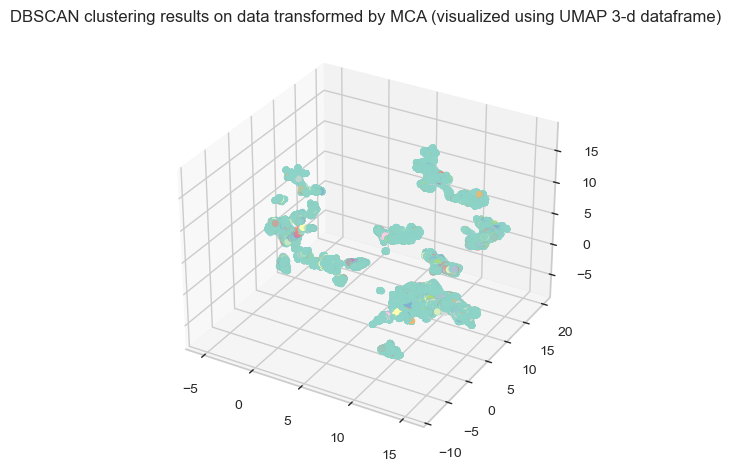

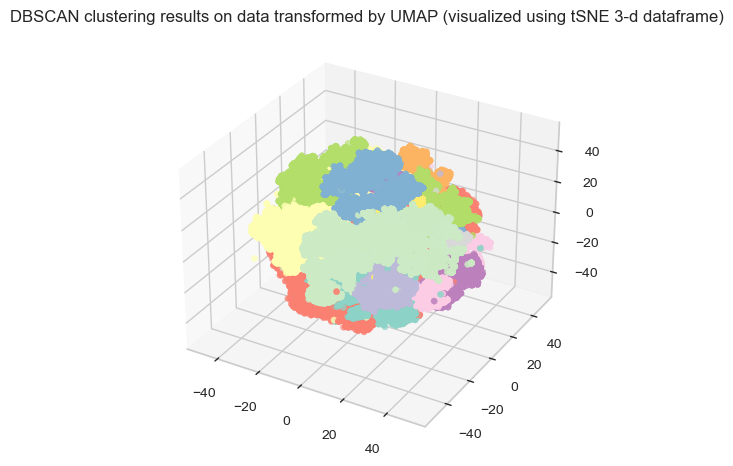

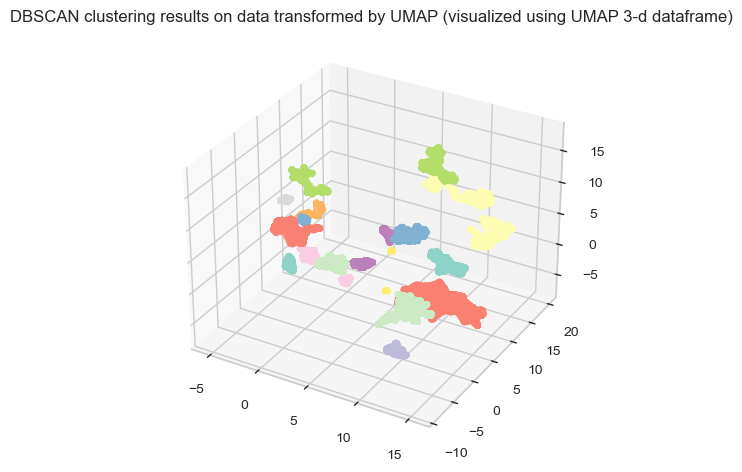

In [11]:
# Iterate through transformed data frames obtained using various dimensionality reduction algorithms
for df_transformed, df_transformed_name in zip([df_tsne, df_pca, df_mca, df_umap],
                                               ["tSNE", "PCA", "MCA", "UMAP"]):
    # Initialize the DBSCAN model
    dbscan = DBSCAN(eps=0.85, min_samples=8)

    # Fit the DBSCAN model
    dbscan_cluster = dbscan.fit_predict(df_transformed)
    
    # Insert the data into the DataFrame
    clustering_results_df.loc[:, ('dbscan', df_transformed_name)] = dbscan_cluster

    # Iterate through "visualization" dataframes (the 3-d ones, to visualize results of the clustering step above)
    for df_vis, df_vis_name in zip([df_tsne, df_umap], ["tSNE", "UMAP"]):
        df_visual = df_vis.copy()
        df_visual["dbscan_cluster"] = dbscan_cluster

        x = df_visual['col_0']
        y = df_visual['col_1']
        z = df_visual['col_2']
        colors = df_visual['dbscan_cluster']

        # Choose a colormap (replace 'coolwarm' with the desired colormap)
        colormap = plt.get_cmap('Set3')

        # Create a 3D scatter plot
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x, y, z, c=colors, cmap=colormap)

        # Set a title for the plot
        ax.set_title('DBSCAN clustering results on data transformed by {} (visualized using {} 3-d dataframe)'.format(
            df_transformed_name, df_vis_name))
        
        # Define the file name
        file_name = f'plots/dbscan/{df_transformed_name}_df_represented_by_{df_vis_name}.png'

        # Remove the existing file if it exists
        try:
            os.remove(file_name)
        except OSError:
            pass

        # Save the plot as an image file (e.g., PNG)
        plt.savefig(file_name)

        # Show the plot
        plt.show()

### Run the cell below to construct an interactive 3-d graphs

In [19]:
# for df_transformed, df_transformed_name in zip([df_umap],
#                                                ["UMAP"]):
#     for df_vis, df_viz_name in zip([df_tsne, df_umap], ["tSNE", "UMAP"]):
#         df_visual = df_vis.copy()
#         selected_column = [col for col in clustering_results_df.columns if df_transformed_name in col][0]
#         df_visual["dbscan_cluster"] = clustering_results_df[selected_column]
#         fig = px.scatter_3d(df_visual, x='col_0', y='col_1', z='col_2', color="dbscan_cluster",
#                            title='DBSCAN clustering results on data transformed by {} (visualized using {} 3-d dataframe)'
#                               .format(df_transformed_name, df_viz_name))
#         fig.show()

In [25]:
clustering_results_df['dbscan']['UMAP'].value_counts()

5     32579
3     13556
2      7655
6      6277
1      6070
18     6002
11     5603
8      4552
17     4351
16     3015
10     2388
4      2262
0      1991
9      1848
13     1263
15     1097
7      1085
12      877
14      461
19      301
20      185
Name: UMAP, dtype: int64

In [ ]:
# Agglomerative clustering takes too much memory. My computer crushes when I run code below to build the dendogram.

In [ ]:
# from scipy.cluster.hierarchy import dendrogram, linkage
# linkage_matrix = linkage(df_umap, method='ward')
# dendrogram(linkage_matrix)
# plt.title('Dendrogram')
# plt.xlabel('Data Points')
# plt.ylabel('Distance')
# plt.show()

In [56]:
# # List of dimensionality reduction algorithms
# dimensionality_reduction_algorithms = ['tSNE', 'PCA', 'MCA', 'UMAP']

# # List of clustering algorithms
# clustering_algorithms = ['kmeans', 'dbscan']

# # Create a MultiIndex
# multiindex = pd.MultiIndex.from_product([clustering_algorithms, dimensionality_reduction_algorithms],
#                                        names=[ 'Clustering', 'Dimensionality Reduction'])

# # Assign the MultiIndex to the DataFrame
# clustering_results_df.columns = multiindex

---

## <span style='color:#ff5f27'>🧮 Comparing different clustering algorithms mathematically

1. Silhouette Score: The Silhouette Score measures how close each data point in one cluster is to the points in the neighboring clusters. A higher Silhouette Score indicates better-defined clusters. You can calculate the Silhouette Score for different k values and **choose the one with the highest score**.

2. Davies-Bouldin Index: The Davies-Bouldin Index measures the average similarity between each cluster and its most similar cluster. Lower values indicate better clustering. Compute the Davies-Bouldin Index for different k values and **choose the one with the lowest value**.

3. Calinski-Harabasz Index (Variance Ratio Criterion): This index measures the ratio of between-cluster variance to within-cluster variance. Higher values indicate better-defined clusters. Like the other metrics, compute this for different k values and **choose the one with the highest value**.

In [48]:
dataframes = [df_pca, df_mca, df_umap]
dimensionality_reduction_algorithms = ['PCA', 'MCA', 'UMAP']
clustering_algorithms = ['kmeans', 'dbscan']  # You can add more algorithms here

results = []

for df, algorithm in zip(dataframes, dimensionality_reduction_algorithms):
    for cluster_algorithm in clustering_algorithms:
        # Get the corresponding cluster assignments from clustering_results_df
        cluster_column_name = f'{cluster_algorithm}_clusters_on_{algorithm}_df'
        
        # Check if the cluster column exists in the DataFrame
        if cluster_column_name in clustering_results_df.columns:
            clusters = clustering_results_df[cluster_column_name]
            
            # Assign cluster assignments to the dataframe
            df['col_cluster'] = clusters

            print(f"Processing {algorithm}-transformed dataframe with {cluster_algorithm}...")
            print()

            print("Computing Silhouette Score...")
            # Compute Silhouette Score
            silhouette = silhouette_score(df, df['col_cluster'])

            print("Computing Davies-Bouldin Index...")
            # Compute Davies-Bouldin Index
            davies_bouldin = davies_bouldin_score(df, df['col_cluster'])

            print("Computing Calinski-Harabasz Index...")
            # Compute Calinski-Harabasz Index
            calinski_harabasz = calinski_harabasz_score(df, df['col_cluster'])

            # Store the results in a dictionary
            result = {
                'Dimensionality Reduction Algorithm': algorithm,
                'Clustering Algorithm': cluster_algorithm,
                'Silhouette Score': silhouette,
                'Davies-Bouldin Index': davies_bouldin,
                'Calinski-Harabasz Index': calinski_harabasz
            }
            results.append(result)

            print()

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)


Processing PCA-transformed dataframe with kmeans...

Computing Silhouette Score...
Computing Davies-Bouldin Index...
Computing Calinski-Harabasz Index...

Processing PCA-transformed dataframe with dbscan...

Computing Silhouette Score...
Computing Davies-Bouldin Index...
Computing Calinski-Harabasz Index...

Processing MCA-transformed dataframe with kmeans...

Computing Silhouette Score...
Computing Davies-Bouldin Index...
Computing Calinski-Harabasz Index...

Processing MCA-transformed dataframe with dbscan...

Computing Silhouette Score...
Computing Davies-Bouldin Index...
Computing Calinski-Harabasz Index...

Processing UMAP-transformed dataframe with kmeans...

Computing Silhouette Score...
Computing Davies-Bouldin Index...
Computing Calinski-Harabasz Index...

Processing UMAP-transformed dataframe with dbscan...

Computing Silhouette Score...
Computing Davies-Bouldin Index...
Computing Calinski-Harabasz Index...



1. Silhouette Score: The Silhouette Score measures how close each data point in one cluster is to the points in the neighboring clusters. A higher Silhouette Score indicates better-defined clusters. You can calculate the Silhouette Score for different k values and **choose the one with the highest score**.

2. Davies-Bouldin Index: The Davies-Bouldin Index measures the average similarity between each cluster and its most similar cluster. Lower values indicate better clustering. Compute the Davies-Bouldin Index for different k values and **choose the one with the lowest value**.

3. Calinski-Harabasz Index (Variance Ratio Criterion): This index measures the ratio of between-cluster variance to within-cluster variance. Higher values indicate better-defined clusters. Like the other metrics, compute this for different k values and **choose the one with the highest value**.

In [49]:
results_df

,Dimensionality Reduction Algorithm,Clustering Algorithm,Silhouette Score,Davies-Bouldin Index,Calinski-Harabasz Index
0,PCA,kmeans,0.184680,1.926219,1.923208e+04
1,PCA,dbscan,0.254664,0.262422,2.238561e+06
2,MCA,kmeans,0.304994,1.395181,6.858641e+04
3,MCA,dbscan,0.510058,0.538204,1.000371e+05
4,UMAP,kmeans,0.587598,0.624812,1.045319e+05
5,UMAP,dbscan,0.695301,0.337564,1.613848e+05
